In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/MyDrive/super-resolution

/content/drive/MyDrive/super-resolution


In [3]:
%pwd

'/content/drive/MyDrive/super-resolution'

In [4]:
import cv2
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from metrics import psnr, ssim
from unet import create_unet_model

Load data

In [5]:
input_folder = "./images"

image_files = [f for f in os.listdir(input_folder) if f.endswith(".png") or f.endswith(".jpg")]

images_Y = [cv2.imread(os.path.join(input_folder, img)) for img in image_files]

images_X = [cv2.resize(img, (48, 48), interpolation=cv2.INTER_AREA) for img in images_Y]

images_X = [img / 255.0 for img in images_X]
images_Y = [img / 255.0 for img in images_Y]

images_X = np.array(images_X)
images_Y = np.array(images_Y)

X_train, X_test, Y_train, Y_test = train_test_split(images_X, images_Y, test_size=0.2, random_state=42)

print(X_train.shape)
print(Y_train.shape)
print(type(X_train))

(4000, 48, 48, 3)
(4000, 96, 96, 3)
<class 'numpy.ndarray'>


In [10]:
model_unet = create_unet_model()
model_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv2d_17 (Conv2D)          (None, 48, 48, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_18 (Conv2D)          (None, 48, 48, 64)           36928     ['conv2d_17[0][0]']           
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 64)           0         ['conv2d_18[0][0]']           
 g2D)                                                                                       

In [11]:
model_unet.compile(optimizer='adam', loss='mean_squared_error', metrics=[psnr, ssim])

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [13]:
history = model_unet.fit(X_train, Y_train, epochs=100, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
200/200 [==============================] - 15s 50ms/step - loss: 0.0142 - psnr: 20.5533 - ssim: 0.6571 - val_loss: 0.0047 - val_psnr: 23.7999 - val_ssim: 0.7854
Epoch 2/100
200/200 [==============================] - 9s 43ms/step - loss: 0.0039 - psnr: 24.6756 - ssim: 0.8167 - val_loss: 0.0031 - val_psnr: 25.5894 - val_ssim: 0.8374
Epoch 3/100
200/200 [==============================] - 9s 46ms/step - loss: 0.0030 - psnr: 25.8448 - ssim: 0.8451 - val_loss: 0.0029 - val_psnr: 25.9207 - val_ssim: 0.8472
Epoch 4/100
200/200 [==============================] - 9s 43ms/step - loss: 0.0027 - psnr: 26.3588 - ssim: 0.8546 - val_loss: 0.0026 - val_psnr: 26.5155 - val_ssim: 0.8588
Epoch 5/100
200/200 [==============================] - 9s 47ms/step - loss: 0.0026 - psnr: 26.5083 - ssim: 0.8585 - val_loss: 0.0025 - val_psnr: 26.7994 - val_ssim: 0.8612
Epoch 6/100
200/200 [==============================] - 9s 43ms/step - loss: 0.0026 - psnr: 26.6146 - ssim: 0.8613 - val_loss: 0.0026 - val_

In [14]:
model_unet.save('unet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
model_unet.evaluate(X_test, Y_test)

32/32 [==============================] - 4s 49ms/step - loss: 0.0019 - psnr: 28.1405 - ssim: 0.8878


[0.001937813707627356, 28.140472412109375, 0.8877843022346497]

In [16]:
metrics = pd.DataFrame(history.history)
metrics

,loss,psnr,ssim,val_loss,val_psnr,val_ssim
0,0.014179,20.553289,0.657083,0.004740,23.799917,0.785375
1,0.003933,24.675625,0.816747,0.003142,25.589390,0.837418
2,0.003010,25.844812,0.845052,0.002912,25.920725,0.847214
3,0.002701,26.358816,0.854569,0.002593,26.515509,0.858827
4,0.002618,26.508316,0.858533,0.002456,26.799438,0.861166
5,0.002564,26.614626,0.861277,0.002616,26.438643,0.859745
6,0.002530,26.680620,0.862863,0.002334,27.054411,0.867236
7,0.002430,26.882149,0.865783,0.002321,27.072895,0.868049
8,0.002420,26.900623,0.867102,0.002260,27.214268,0.871369
9,0.002417,26.907673,0.868239,0.002222,27.301170,0.871503


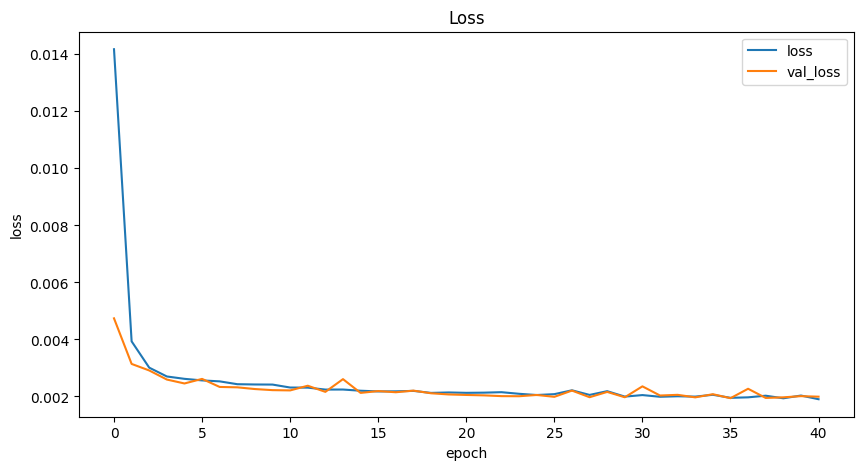

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(metrics['loss'], label='loss')
plt.plot(metrics['val_loss'], label='val_loss')
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

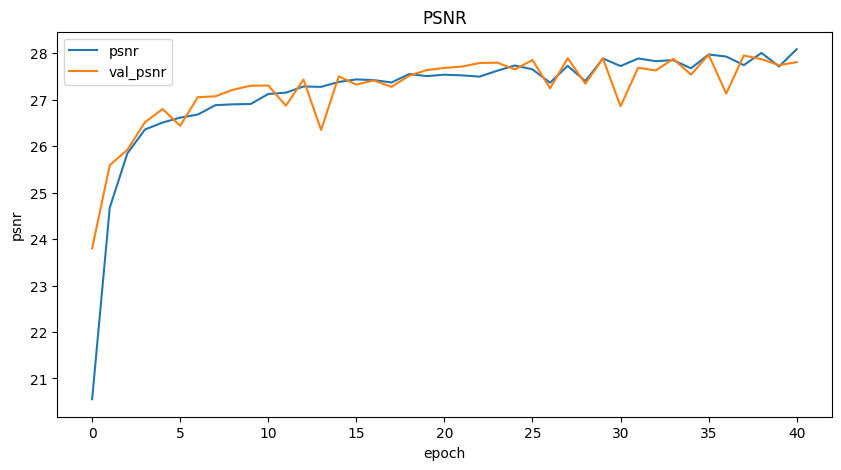

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(metrics['psnr'], label='psnr')
plt.plot(metrics['val_psnr'], label='val_psnr')
plt.title('PSNR')
plt.xlabel('epoch')
plt.ylabel('psnr')
plt.legend()
plt.show()

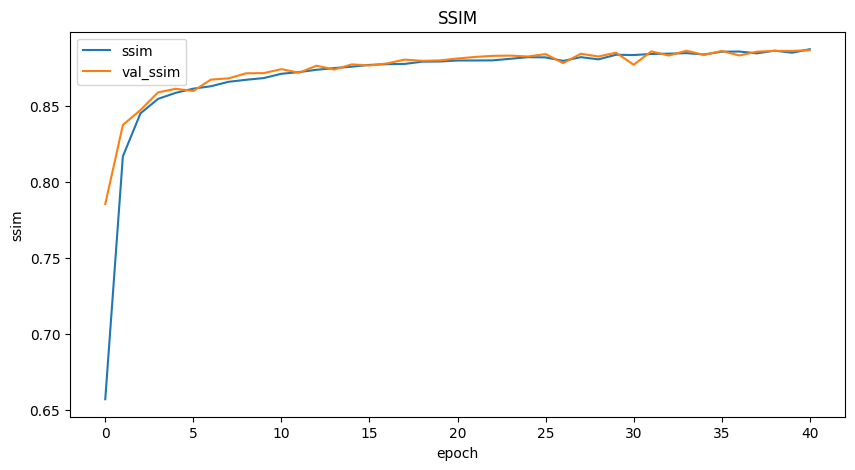

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(metrics['ssim'], label='ssim')
plt.plot(metrics['val_ssim'], label='val_ssim')
plt.title('SSIM')
plt.xlabel('epoch')
plt.ylabel('ssim')
plt.legend()
plt.show()

In [20]:
print(X_test.shape)
print(X_test[0].shape)

sample = np.reshape(X_test[0], (1, X_test[0].shape[0], X_test[0].shape[1], X_test[0].shape[2]))
print(sample.shape)

predicted_image = model_unet.predict(sample)

(1000, 48, 48, 3)
(48, 48, 3)
(1, 48, 48, 3)
1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'Original')

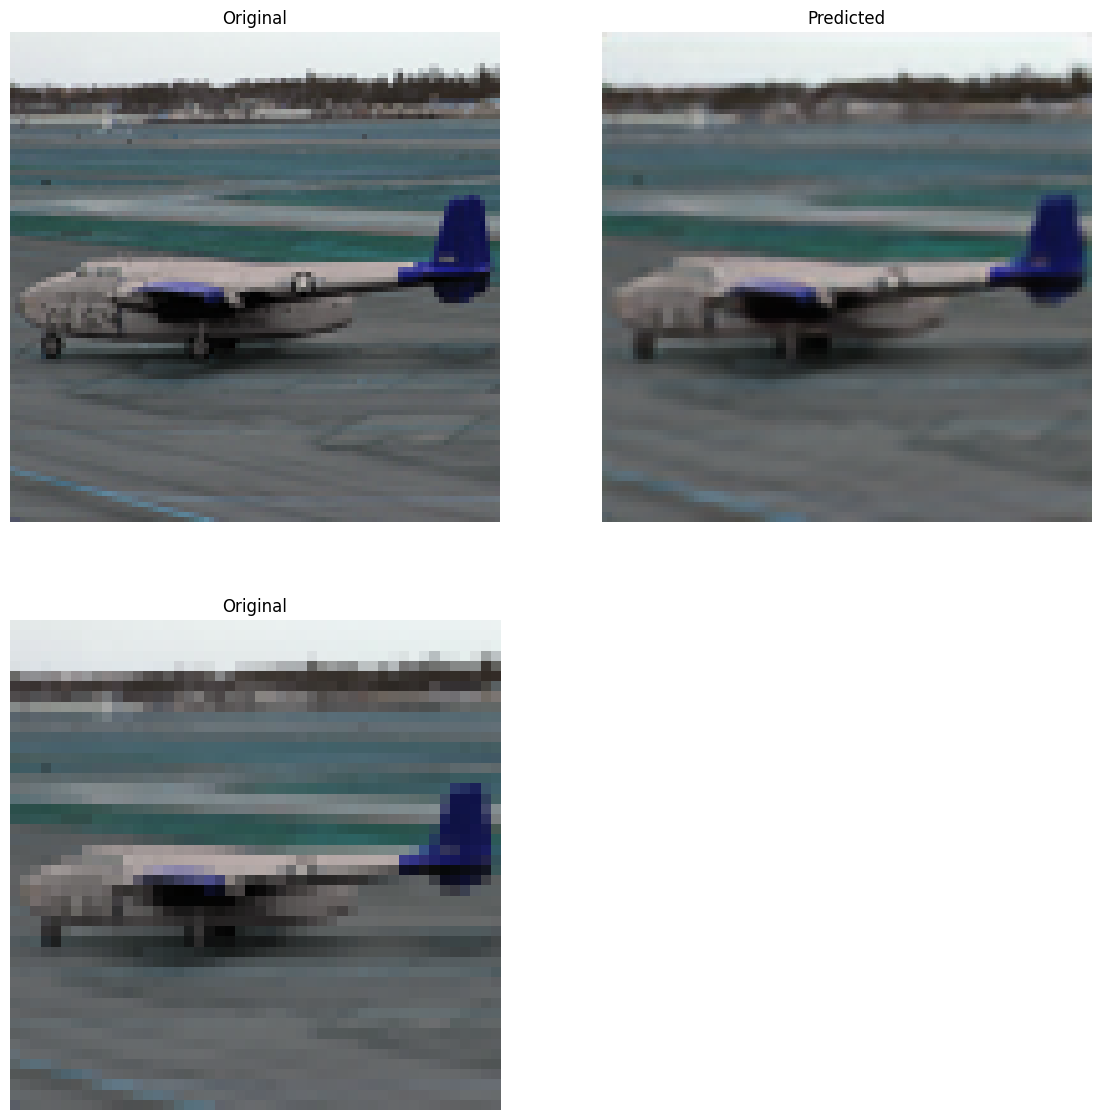

In [24]:
plt.figure(figsize=(14,14))
plt.subplot(2, 2, 1)
plt.imshow(Y_test[0])
plt.axis('off')
plt.title('Original')

plt.subplot(2, 2, 2)
predicted_image = np.reshape(predicted_image, (96, 96, 3))
plt.imshow(predicted_image)
plt.axis('off')
plt.title('Predicted')

plt.subplot(2, 2, 3)
plt.imshow(X_test[0])
plt.axis('off')
plt.title('Original')